# 1. Import Depedencies

In [1]:
# Install Depedencies
!pip -q install hpelm

# Import Depedencies
import os
import warnings
import numpy as np
import tensorflow as tf
import seaborn as sns
import random
import pandas as pd
import cv2
from hpelm import ELM
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
warnings.filterwarnings("ignore")

# 2. Data Preparation

In [2]:
# create dataframe from file path
dataset_path = "../input/utkface-new/UTKFace" 
images = np.array([])
ages = np.array([])

for filename in os.listdir(dataset_path):
    ages = np.append(ages, filename.split('_')[0])
    images = np.append(images, f"../input/utkface-new/UTKFace/{filename}")
    
images = pd.Series(images, name = "Name")
ages = pd.Series(ages, name ="Age", dtype = 'int')
df = pd.concat([images,ages], axis = 1)
df.head()

,Name,Age
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17


In [3]:
# Classifying Age Into Several Groups (Adiance Dataset Group)
def ages_group(age):
    
    if(0 <= age <= 2):
        return "0 - 2"
    elif(4 <= age <= 6):
        return "4 - 6"
    elif(8 <= age <= 13):
        return "8 - 13"
    elif(15 <= age <= 20):
        return "15 - 20"
    elif(25 <= age <= 32):
        return "25 - 32"
    elif(38 <= age <= 43):
        return "38 - 43"
    elif(48 <= age <= 53):
        return "48 - 53"
    elif(age >= 60):
        return "60++"
    else:
        return "no group"
    
ages_group = pd.Series(df['Age'].apply(ages_group), name = "Group")
df_group = pd.concat([df, ages_group], axis = 1)
df_group = df_group[df_group["Group"] != 'no group'].reset_index(drop = True)
df_group.head()

,Name,Age,Group
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,25 - 32
1,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,25 - 32
2,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,15 - 20
3,../input/utkface-new/UTKFace/76_0_0_2017010421...,76,60++
4,../input/utkface-new/UTKFace/18_1_0_2017010402...,18,15 - 20


# 3. Predicting Images

In [31]:
def get_model(model_name):
    cnn_layer =  tf.keras.models.load_model(f'../input/cnnelmmodel2/CNN ELM Model/{model_name}/feature_extractor.h5')
    classifier = ELM(inputs = cnn_layer.output.shape[-1], outputs = 8)
    classifier.load(f'../input/cnnelmmodel2/CNN ELM Model/{model_name}/elm_classifier.pkl')
    
    return cnn_layer, classifier

def predict(input, cnn_layer, classfier):
    # Extract Features
    features = np.array(cnn_layer(input)) 

    # predict with ELM
    pred = classfier.predict(features)
    
    return pred

def get_age_label(input):
    classes = {
        0 : "0 - 2",
        1 : "4 - 6",
        2 : "8 - 13",
        3 : "15 - 20",
        4 : "25 - 32",
        5 : "38 - 43",
        6 : "48 - 53",
        7 : "60++"
    }
    return classes[np.argmax(input)]

def predict_sample(cnn_layer, classfier, samples):
    plt.figure(figsize = (15, 38))
    plot = 0
    for i in samples:
        img = mpimg.imread(df_group.iloc[i]['Name'])
        img = cv2.resize(img, (224,224)) / 255.
        pred = predict(np.expand_dims(img, axis = 0), cnn_layer, classfier)
        pred = get_age_label(pred)
        label = df_group.iloc[i]['Group']
        plot += 1
        plt.subplot(10, 5, plot) 
        plt.imshow(img)
        plt.title(f"Predicted {pred} Years Old", c = 'red' if pred != label else 'black')
        plt.xlabel(f"Actual is {label} Years Old",fontsize =12)
        plt.xticks([])
        plt.yticks([])

    plt.show()

In [32]:
# ResNet50 (imgnet)
resnet50_imgnet, resnet50_imgnet_classfier = get_model('ResNet50+imgnet+ELM')

# ResNet50 (vggface)
resnet50_vggface, resnet50_vggface_classfier = get_model('ResNet50+vggface+ELM')

# VGG16 (imgnet)
vgg16_imgnet, vgg16_imgnet_classfier = get_model('Vgg16+imgnet+ELM')

# VGG16(vggface)
vgg16_vggface, vgg16_vggface_classfier = get_model('Vgg16+vggface+ELM')

In [33]:
# Random id sample
rand_idx = np.random.randint(low = 0, high = len(df_group), size=20)
print(rand_idx)

[10205 16478 15376  6879  3298 10050  7626 12828  1935 12104 12290  9608
   857 12634  6768 12123  2559  9937  3721  5042]


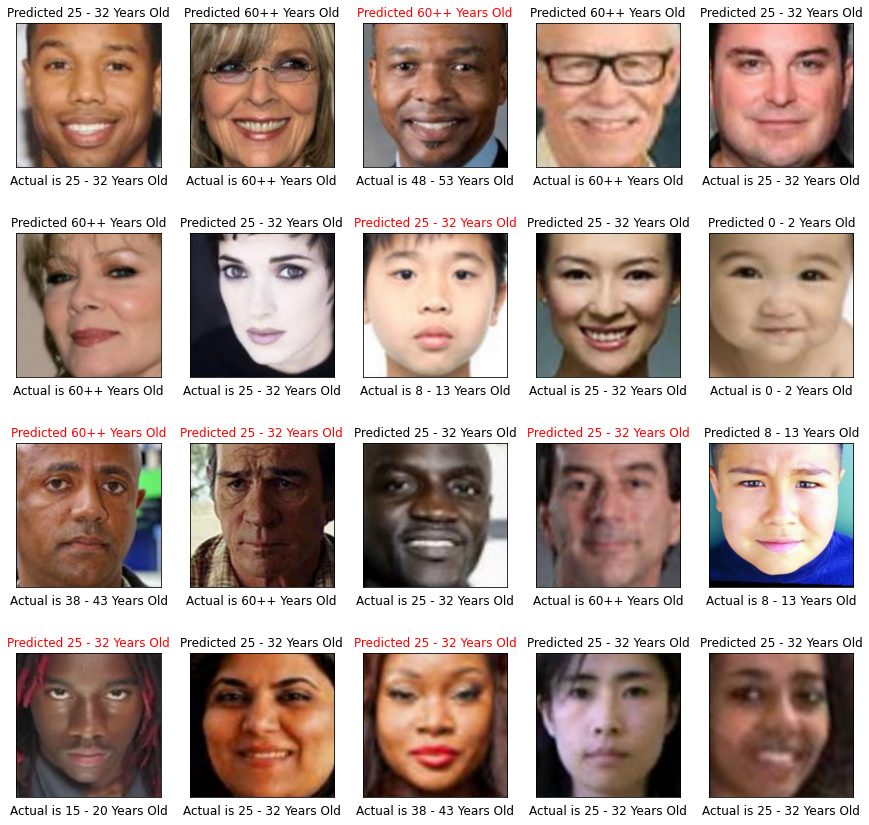

In [34]:
# Predict with ResNet50 (imgnet)
predict_sample(resnet50_imgnet, resnet50_imgnet_classfier, rand_idx)

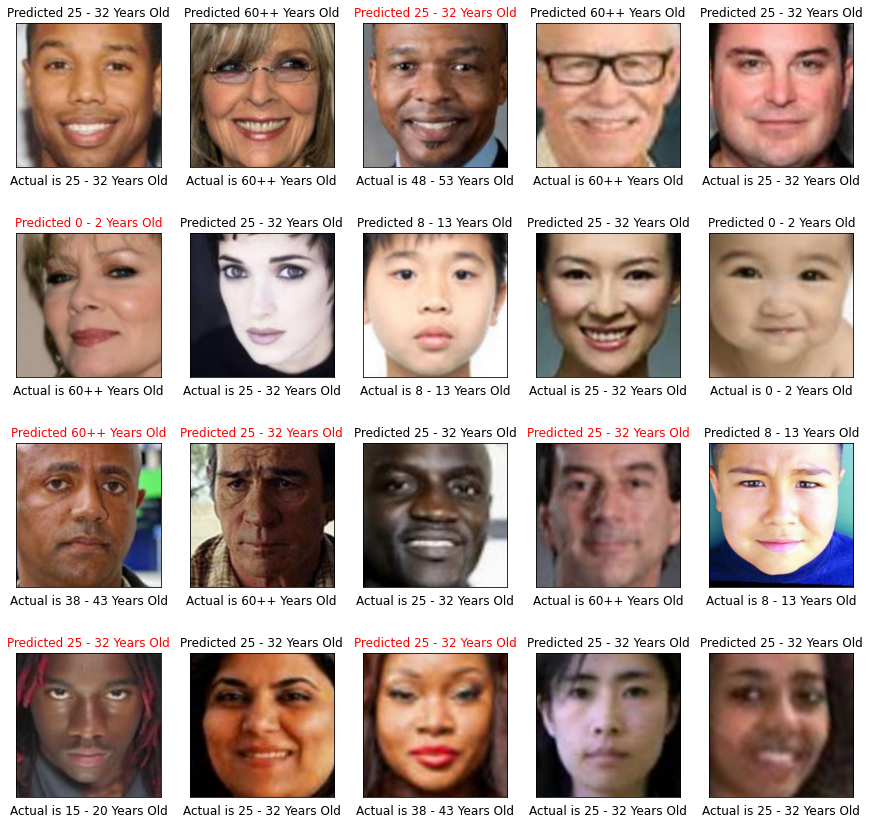

In [35]:
# Predict with ResNet50(vggface)
predict_sample(resnet50_vggface, resnet50_vggface_classfier, rand_idx)

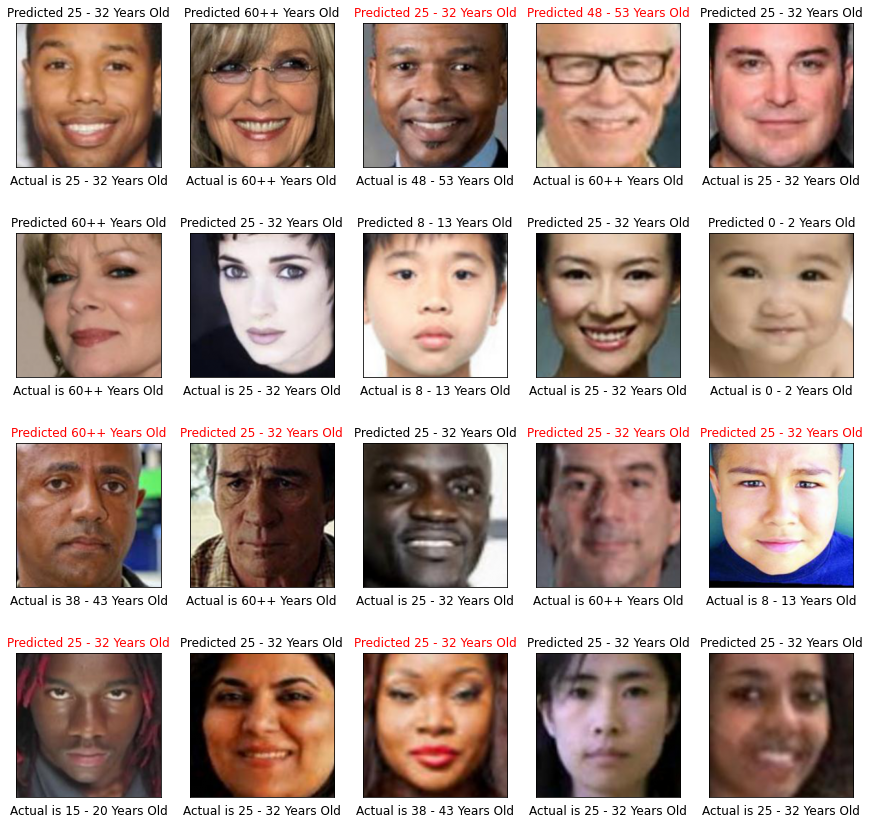

In [36]:
# Predict with VGG16(imgnet)
predict_sample(vgg16_imgnet, vgg16_imgnet_classfier , rand_idx)

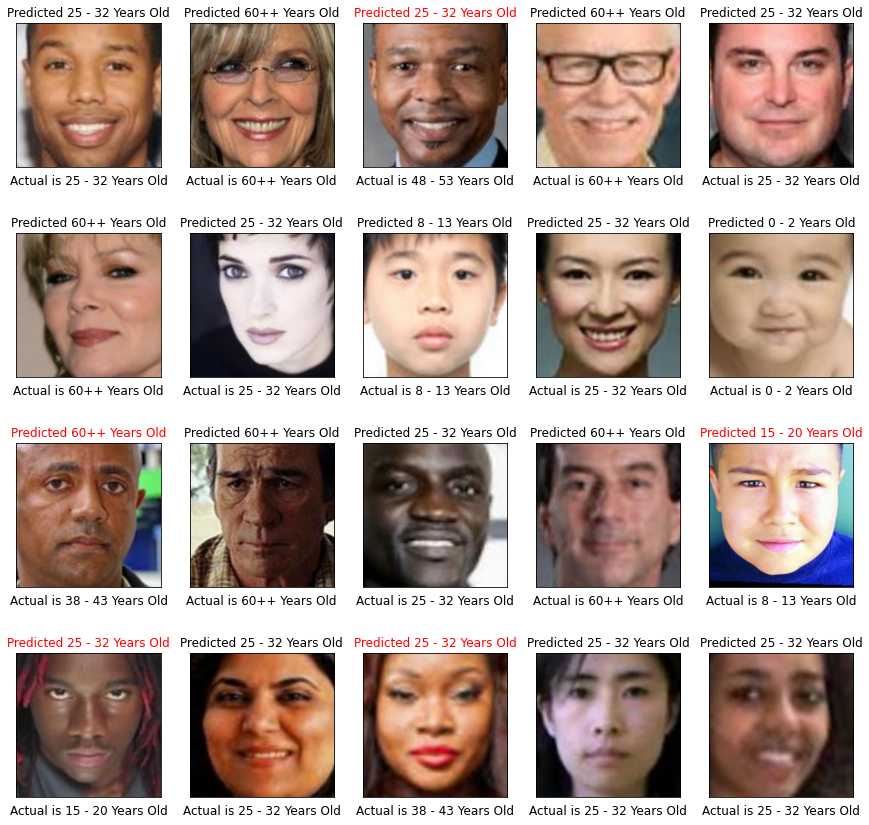

In [37]:
# Predict with VGG16(vggface)
predict_sample(vgg16_vggface, vgg16_vggface_classfier, rand_idx)